In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from scipy.signal import wiener
from skimage import color,data,restoration
from scipy.signal import convolve2d
from __future__ import division
import scipy.stats as stats

%matplotlib inline

In [2]:
    
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values
    
#########  Using guide from following web page to obtaine power spectrum
####   https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    
def PpectrumNormed(Title,file,filtervalue=-1,img=[],bgn=[]):
    if(file):
        Values=PickleITRead(file)
        img=Values["PSData"]
        bgn=Values["PSBg"]
        
    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
    ## Normalize it
    knrm=np.sqrt(kfreq2D[0]**2+kfreq2D[1]**2)

    ## Convert it to 1d array
    knrm=knrm.flatten()
    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
   
    kbins = np.arange(0.5, npix//2+1, 1.)
    #kbins = np.arange(1, npix, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackground, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackground *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgY=Abins/kvals
    BgY=AbinsBackground/kvals
    
    ### Mask it
    xlow=20
    xhigh=256
    Mask=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))


    
    IntegralBG=np.trapz(BgY[Mask],dx=1)
    IntegralSig=np.trapz(ImgY[Mask],dx=1)
    BgNormed=BgY*(IntegralSig/IntegralBG)
    
    weiner=(ImgY-BgNormed)/ImgY
    weinerNormed=(np.trapz(ImgY,dx=1)/np.trapz(weiner,dx=1))*weiner
    WeinerMask=kvals>=xlow
    
    ## This is forcing remainning values of filtered region to have small values
    if(filtervalue!=-1):
        weinerNormed[WeinerMask]=filtervalue
        weiner[WeinerMask]=filtervalue
    
    

    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.plot(kvals,ImgY,label="signal")
    plt.plot(kvals,BgNormed,label="BackgroundNormed")
    plt.plot(kvals,weinerNormed,label="Weiner")

    plt.loglog()
    plt.axvline(xlow,color='r')
    plt.axvline(xhigh,color='r',label="IntegrationWindow")
  
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    if(file):
        Values["Wiener1d"]=weiner
        PickleITDump(Values,file)
    
    return weiner
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")
    
def Padding(Wiener1d,value):
    ### Increase array size to 512 
    if(len(Wiener1d)<512):
        for i in range (0, 256):
            Wiener1d=np.append(Wiener1d,value)
    return Wiener1d
        

In [3]:
### Values in Dictionary
## "bgns" --> Averaged Bgn
## "imgs" --> Averaged Signal
## "PSData" --> Averaged Signal Power Spectrum
## "PSBg" --> Averaged Background Power Spectrum
## "Wiener1D" -->  Wiener1D obtained using PpectrumNormed function
## "Wiener2D" -->  (PsImg-PsBgN)/PsImg

In [4]:
#### Day 1
WienerDay1=PickleITRead("WienerDay1.p")

Minimum kval = 1.0 and Maximum kval= 256.0


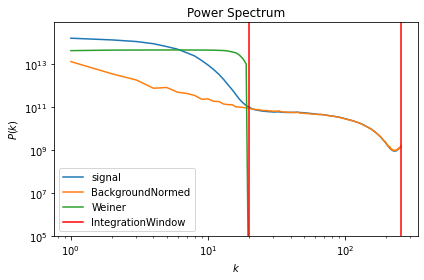

In [5]:
Wiener1D=PpectrumNormed("Power Spectrum","WienerDay1.p",filtervalue=0.3)
## Adding small values  to make the array 512 for 1D Wiener
Wiener1D=Padding(Wiener1D,0.3)

#Wiener2D=WienerDay1["Wiener2D"]

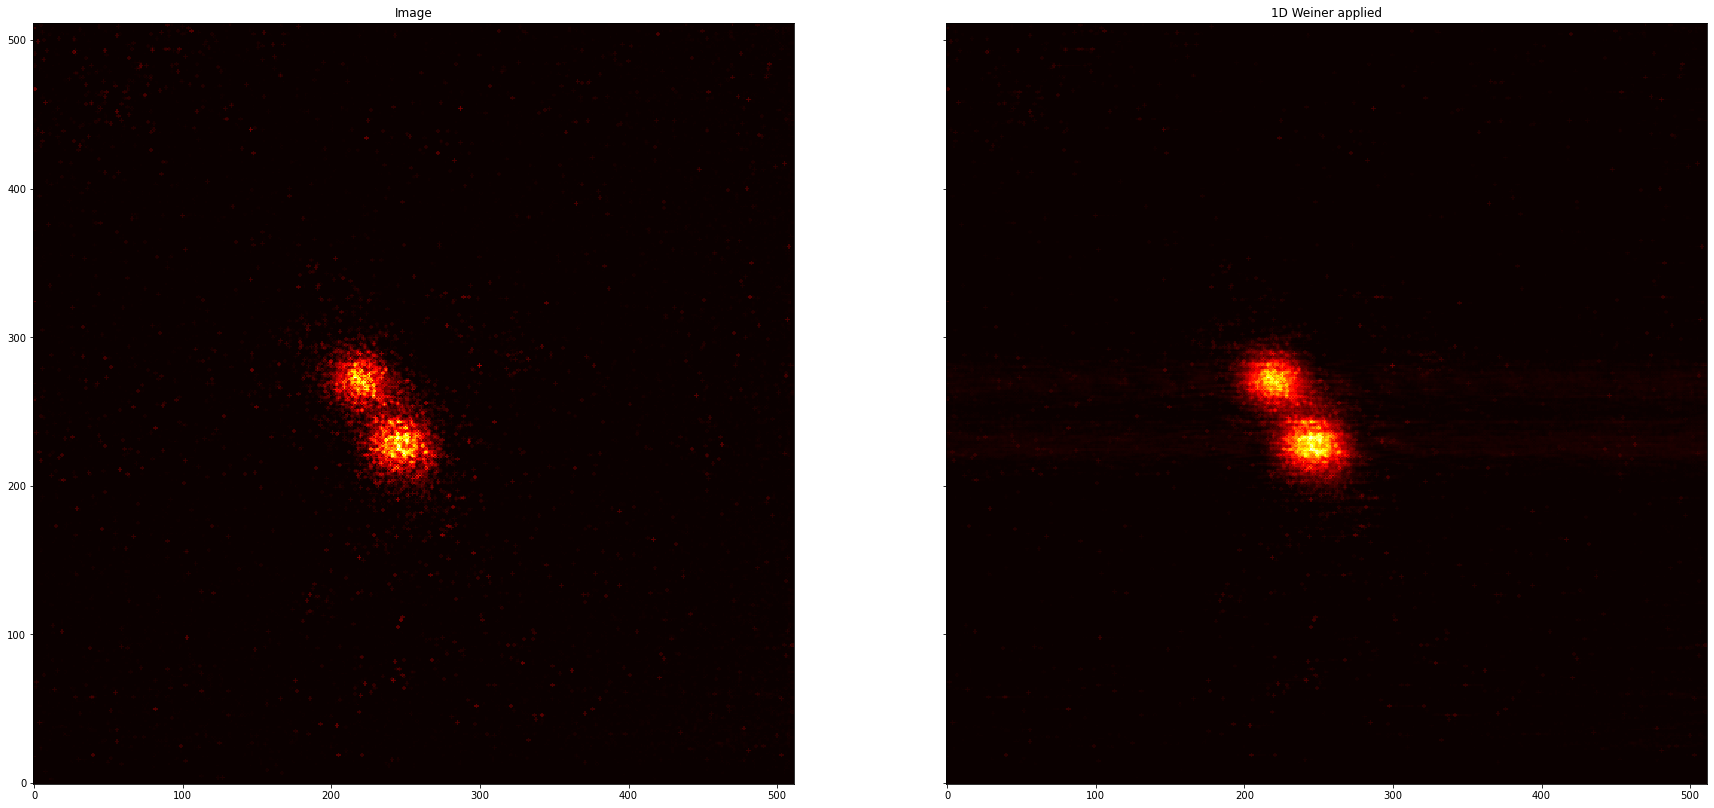

In [14]:
#### Single Image Recovery Day 1
SingleImg=getImageValues("Images/Day1/signal/2.tif")

## Power Sp for one image
fft_SingleImg=np.fft.fft2(SingleImg)
PS_SingleImg=(np.abs(fft_SingleImg))**2

## 2D wiener
#RestoredWiener2D = np.fft.ifft2(fft_SingleImg*Wiener2D)
#RestoredWiener2D = np.real(RestoredWiener2D)

## 1D Wiener

RestoredWiener1D = np.fft.ifft2(fft_SingleImg*Wiener1D)
RestoredWiener1D = np.real(RestoredWiener1D)

# take real() component (or do abs())


# clip and convert to uint8
#SingleImg=SingleImg.clip(0,255).astype(np.uint8)
#RestoredWiener1D = RestoredWiener1D.clip(0,255).astype(np.uint8)
#RestoredWiener2D = RestoredWiener2D.clip(0,255).astype(np.uint8)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('Image')
ax[0].imshow(SingleImg,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(SingleImg)), vmax=np.max(SingleImg))
ax[1].set_title('1D Weiner applied')
ax[1].imshow(RestoredWiener1D,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(RestoredWiener1D)), vmax=np.max(RestoredWiener1D))
#ax[2].set_title('2D Weiner applied')
#ax[2].imshow(RestoredWiener2D,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(RestoredWiener2D)), vmax=np.max(RestoredWiener2D))





In [7]:
#### Day 2
WienerDay2=PickleITRead("WienerDay2.p")

Minimum kval = 1.0 and Maximum kval= 256.0


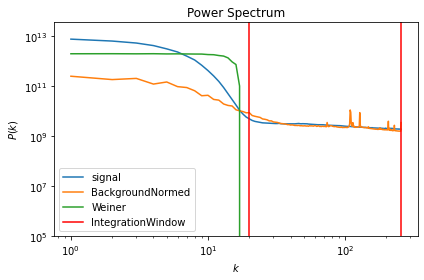

In [8]:
Wiener1D=PpectrumNormed("Power Spectrum","WienerDay2.p",filtervalue=0.3)
## Adding small values  to make the array 512 for 1D Wiener
Wiener1D=Padding(Wiener1D,0.3)

#Wiener2D=WienerDay2["Wiener2D"]

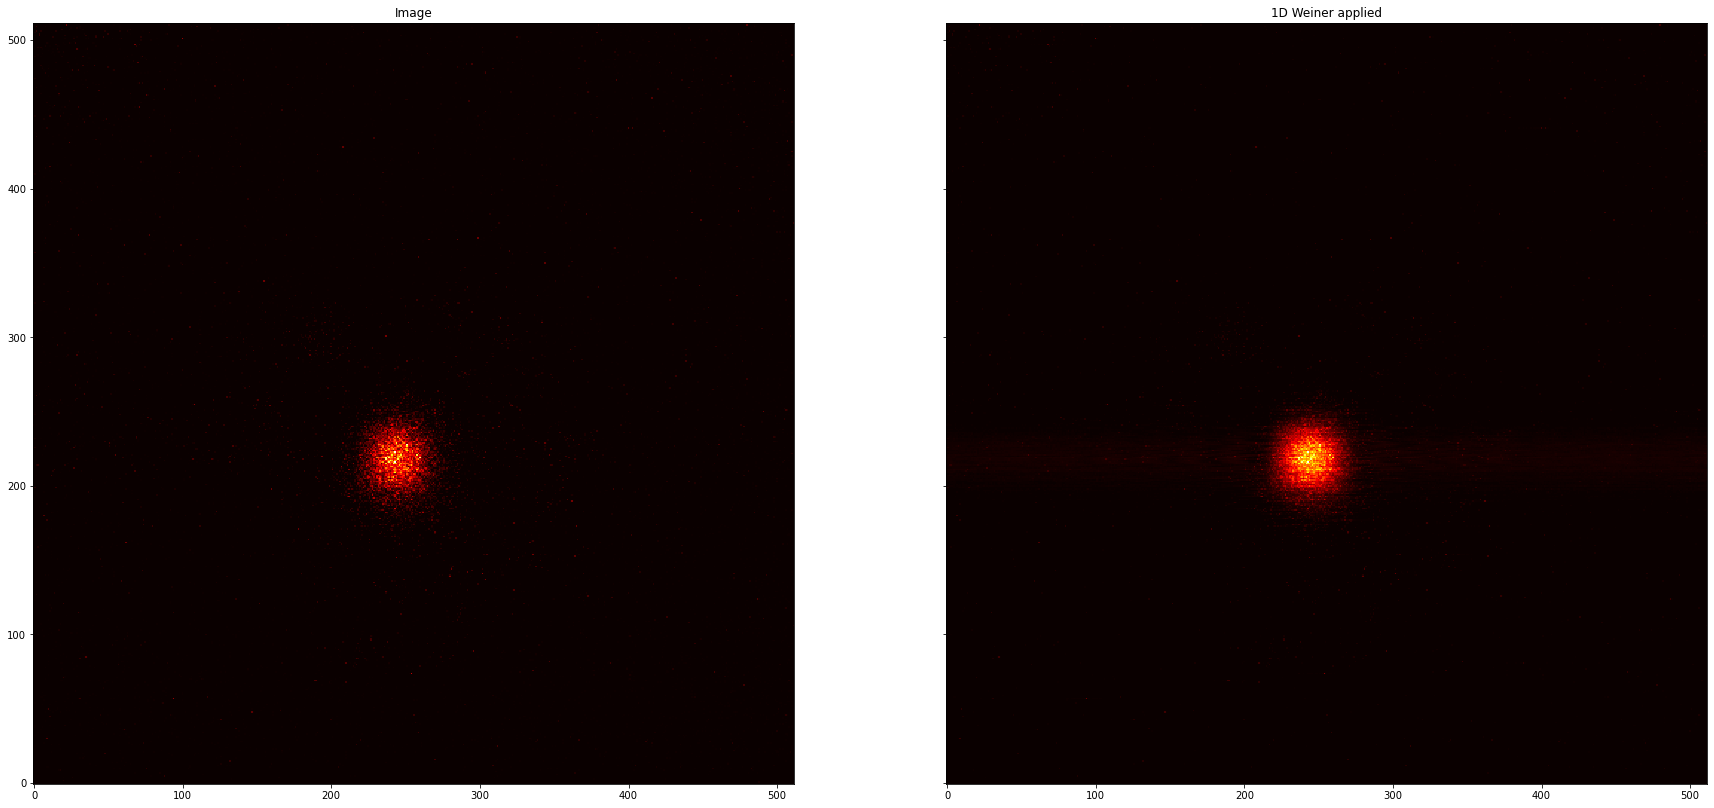

In [20]:
#### Single Image Recovery Day 1
SingleImg=getImageValues("Images/Day2/signal/3.tif")

## Power Sp for one image
fft_SingleImg=np.fft.fft2(SingleImg)
PS_SingleImg=(np.abs(fft_SingleImg))**2

## 2D wiener
#RestoredWiener2D = np.fft.ifft2(fft_SingleImg*Wiener2D)
#RestoredWiener2D = np.real(RestoredWiener2D)

## 1D Wiener

RestoredWiener1D = np.fft.ifft2(fft_SingleImg*Wiener1D)
RestoredWiener1D = np.real(RestoredWiener1D)

# take real() component (or do abs())


# clip and convert to uint8
#SingleImg=SingleImg.clip(0,255).astype(np.uint8)
#RestoredWiener1D = RestoredWiener1D.clip(0,255).astype(np.uint8)
#RestoredWiener2D = RestoredWiener2D.clip(0,255).astype(np.uint8)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
ax[0].set_title('Image')
ax[0].imshow(SingleImg,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(SingleImg)), vmax=np.max(SingleImg))
ax[1].set_title('1D Weiner applied')
ax[1].imshow(RestoredWiener1D,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(RestoredWiener1D)), vmax=np.max(RestoredWiener1D))
#ax[2].set_title('2D Weiner applied')
#ax[2].imshow(RestoredWiener2D,cmap=plt.get_cmap('hot'),origin="lower", interpolation='nearest',vmin=(np.mean(RestoredWiener2D)), vmax=np.max(RestoredWiener2D))



